#Import libraries

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [ ]:
torch.cuda.get_device_name(torch.cuda.current_device())

'Tesla P100-PCIE-16GB'

In [ ]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"
device = torch.device(dev) 

#Import CIFAR10 
improve later, lazy not memory efficient

In [ ]:
data_path = '../data'
trainset = datasets.CIFAR10(data_path, train=True, download=True,transform=transforms.Compose([
                              transforms.ToTensor()
                          ]))
traingrey = datasets.CIFAR10(data_path, train=True, download=True,transform=transforms.Compose([
                              transforms.Grayscale(num_output_channels=1),
                              transforms.ToTensor()
                          ]))
testset = datasets.CIFAR10(data_path, train=False, download=True,transform=transforms.Compose([
                              transforms.ToTensor()
                          ]))
testgrey = datasets.CIFAR10(data_path, train=False, download=True,transform=transforms.Compose([
                              transforms.Grayscale(num_output_channels=1),
                              transforms.ToTensor()
                          ]))
img_rows = trainset[0][0].shape[1]
img_cols = trainset[0][0].shape[2]
channels = trainset[0][0].shape[0]

train_color = torch.stack([(img) for img, _ in trainset])
train_grey = torch.stack([(img) for img, _ in traingrey])


test_color = torch.stack([(img) for img, _ in testset])
test_grey = torch.stack([(img) for img, _ in testgrey])

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


#Display RGB and Greyscale images

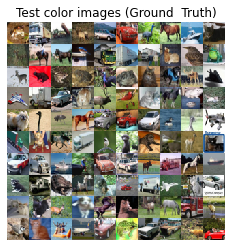

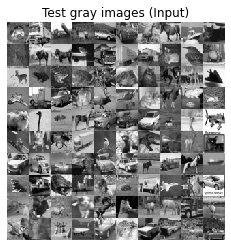

In [ ]:
imgs = (train_color[:100].permute(0,2,3,1)).numpy()
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
# plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

imgs = train_grey[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
# plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

In [ ]:
input_shape = (img_rows, img_cols, 1)
batch_size = 64
kernel_size = 3
latent_dim = 256
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

#Create Custom Datasets

In [ ]:
class TrainSet(Dataset):
  def __init__(self):
    self.color = train_color
    self.grey = train_grey
  def __len__(self):
    return len(self.color)
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    return self.grey[idx],self.color[idx]

In [ ]:
class TestSet(Dataset):
  def __init__(self):
    self.color = test_color
    self.grey = test_grey
  def __len__(self):
    return len(self.color)
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    return self.grey[idx],self.color[idx]

#Model prototypes
DON'T RUN

In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    self.conv1 = nn.Conv2d(1, layer_filters[0], kernel_size=kernel_size, stride=2,padding=1)
    self.conv2 = nn.Conv2d(layer_filters[0],layer_filters[1],kernel_size=kernel_size,stride=2,padding=1)
    self.conv3 = nn.Conv2d(layer_filters[1],layer_filters[2],kernel_size=kernel_size,stride=2,padding=1)
    self.latent = nn.Linear(layer_filters[2]*4*4,latent_dim)
  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = x.view(x.size()[0], -1)#flatten
    latent_v = self.latent(x)
    return latent_v

Decoder Model

In [ ]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()
    self.fc1 = nn.Linear(latent_dim,layer_filters[2]*4*4)
    self.conv_T1 = nn.ConvTranspose2d(layer_filters[1],layer_filters[2],kernel_size=kernel_size,stride=2,padding=1)
    self.conv_T2= nn.ConvTranspose2d(layer_filters[0],layer_filters[1],kernel_size=kernel_size,stride=2,padding=1)
    self.conv_T3 = nn.Conv2d(1, layer_filters[0], kernel_size=kernel_size, stride=2,padding=1)
    self.conv_T4 = nn.ConvTranspose2d(3, layer_filters[0], kernel_size=kernel_size, stride=2,padding=1)
  def forward(self,x):
    x = self.fc1(x)
    x = x.view(-1,channels,4,4)
    x = F.relu(self.conv_T1(x))
    x = F.relu(self.conv_T2(x))
    x = F.relu(self.conv_T3(x))
    output = F.sigmoid(self.conv_t4(x))
    return output

#Autoencoder

In [ ]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder,self).__init__()
    self.conv1 = nn.Conv2d(1, layer_filters[0], kernel_size=kernel_size, stride=2,padding=1)
    self.conv2 = nn.Conv2d(layer_filters[0],layer_filters[1],kernel_size=kernel_size,stride=2,padding=1)
    self.conv3 = nn.Conv2d(layer_filters[1],layer_filters[2],kernel_size=kernel_size,stride=2,padding=1)
    self.latent = nn.Linear(layer_filters[2]*4*4,latent_dim)

    self.fc1 = nn.Linear(latent_dim,layer_filters[2]*4*4)
    self.conv_T1 = nn.ConvTranspose2d(layer_filters[2],layer_filters[2],kernel_size=kernel_size,stride=2,padding=1,output_padding=1)
    self.conv_T2 = nn.ConvTranspose2d(layer_filters[2],layer_filters[1],kernel_size=kernel_size,stride=2,padding=1,output_padding=1)
    self.conv_T3 = nn.ConvTranspose2d(layer_filters[1], layer_filters[0], kernel_size=kernel_size, stride=2,padding=1,output_padding=1)
    self.conv_T4 = nn.ConvTranspose2d(layer_filters[0], 3, kernel_size=kernel_size,padding=1)
  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = x.view(x.size()[0], -1)#torch.flatten(x, 1) #
    latent_v = self.latent(x)
    d = self.fc1(latent_v)
    d = d.view(-1,layer_filters[2],4,4)
    d = F.relu(self.conv_T1(d))
    d = F.relu(self.conv_T2(d))
    d = F.relu(self.conv_T3(d))
    output = torch.sigmoid(self.conv_T4(d))
    return output
Autoencoder()

Autoencoder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (latent): Linear(in_features=4096, out_features=256, bias=True)
  (fc1): Linear(in_features=256, out_features=4096, bias=True)
  (conv_T1): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv_T2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv_T3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv_T4): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

#Train Model

In [ ]:
model = Autoencoder()
model.to(torch.device("cuda:0"))
torch.manual_seed(123)
criterion = nn.MSELoss() # mean square error loss
optimizer = torch.optim.Adam(model.parameters(),lr=0.001) # <--
trainloader = DataLoader(TrainSet(),batch_size=batch_size,num_workers = 1, pin_memory = True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,factor=np.sqrt(0.1),cooldown=0,patience=2,verbose=True,min_lr=0.5e-6)
for epoch in range(30):
  for grey,color in trainloader:
    recon = model(grey.cuda(non_blocking=True))
    loss = criterion(recon, color.cuda(non_blocking=True))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  scheduler.step(loss)
  print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))

Epoch:1, Loss:0.0123
Epoch:2, Loss:0.0101
Epoch:3, Loss:0.0091
Epoch:4, Loss:0.0085
Epoch:5, Loss:0.0081
Epoch:6, Loss:0.0077
Epoch:7, Loss:0.0074
Epoch:8, Loss:0.0072
Epoch:9, Loss:0.0068
Epoch:10, Loss:0.0064
Epoch:11, Loss:0.0059
Epoch:12, Loss:0.0054
Epoch:13, Loss:0.0050
Epoch:14, Loss:0.0042
Epoch:15, Loss:0.0042
Epoch:16, Loss:0.0042
Epoch:17, Loss:0.0043
Epoch:18, Loss:0.0041
Epoch:19, Loss:0.0046
Epoch:20, Loss:0.0037
Epoch:21, Loss:0.0035
Epoch:22, Loss:0.0034
Epoch:23, Loss:0.0034
Epoch:24, Loss:0.0034
Epoch:25, Loss:0.0034
Epoch    26: reducing learning rate of group 0 to 3.1623e-04.
Epoch:26, Loss:0.0034
Epoch:27, Loss:0.0029
Epoch:28, Loss:0.0025
Epoch:29, Loss:0.0024
Epoch:30, Loss:0.0023


In [ ]:
lol = TestSet()
test, truth = lol.__getitem__(list(range(100)))
prediction = model(test.cuda(non_blocking=True))

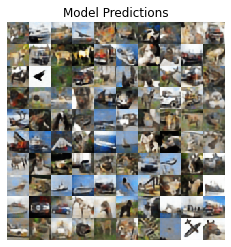

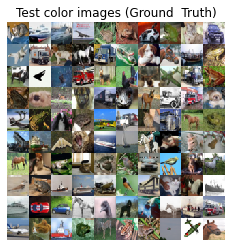

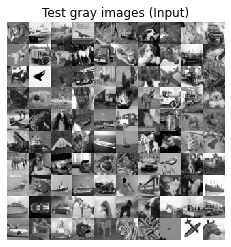

In [ ]:
imgs = (prediction.permute(0,2,3,1)).to("cpu")
imgs = imgs.detach().numpy()
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Model Predictions')
plt.imshow(imgs, interpolation='none')
# plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

imgs = truth.permute(0,2,3,1)
imgs = imgs.detach().numpy()
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.show()


imgs = test
imgs = imgs.to("cpu")
imgs = imgs.detach().numpy()
imgs = imgs.reshape((10, 10, img_rows, img_cols))

imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
model_save_name = 'Autoencoder.pt'
path = F"/content/gdrive/My Drive/Autoencoder-64-2-30-1-0023" 
torch.save(model.state_dict(), path)